# Предсказание риска сердечного приступа

<div>
<b>Заголовок:</b> Предсказание риска сердченого приступа

<b>Описание проекта:</b> На основе датасета из открытого источника необходимо проаналазировать данные, выбрать метрику, обучить модель, предсказывающую риск сердечного приступа. Данные пациентов для предсказания риска сердечных приступов представлены в виде:
- id  - id
- Антропометрические параметры (вес, возраст, рост)
- Привычки (курение, качество сна и т.д)
- Давление
- Наличие хронических заболеваний
- Биохимия крови
- Таргет - высокий или низкий риск поражения сердца

В дальнейшем, модель будет обернута в приложение.   

<b>Цель исследования:</b> Разработать модель, которая позволить предсказать риск сердченого приступа

<b>Ход исследования: </b>
- Подготовка данных: загрузка, изучение общей информации о данных.
- Предобработка данных: удаление дубликатов, очистка данны
- Исследовательский анализ данных: изучение основных параметров, их распределение
- Корреляционный анализ признаков
- Обучение и отбор лучшей модели
- Анализ важности признаков
- Предсказание на тестовых данных

<b>Общий вывод: </b> резюмирование полученных результатов, формулировка ключевых выводов.
</div>

## Импорты

### Импорт библиотек

In [1]:
#основные
import pandas as pd
import numpy as np
import time
#визуализация
import seaborn as sns
import matplotlib.pyplot as plt
#анализ признаков
import phik
import shap
#сохранение модели
import joblib

In [2]:
#пайплайн
from sklearn.model_selection import (
StratifiedKFold,
cross_val_predict,
train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
                            StandardScaler,
                            RobustScaler,
                            MinMaxScaler,
                            OneHotEncoder
                                )

from sklearn.model_selection import RandomizedSearchCV
from optuna.integration import OptunaSearchCV 
from optuna.distributions import IntDistribution
#метрики
from sklearn.metrics import (
                            roc_auc_score,
                            precision_recall_curve,
                            accuracy_score,
                            recall_score,
                            precision_score,
                            fbeta_score
                            )
#модели
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier

### Константы

In [3]:
TEST_SIZE = 0.25
RANDOM_STATE = 703

## Предобработка данных

### Загрузка данных

In [4]:
test = pd.read_csv('heart_test.csv',index_col=0)
train = pd.read_csv('heart_train.csv',index_col=0)

### Просмотр данных

In [5]:
def first_show(data):
    display(data.info())
    display(data.head(10))
    display(data.describe())

Тренировочные данные 

In [6]:
first_show(train)

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level             

None

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047
5,0.168539,0.764286,0.057745,0.0,1.0,1.0,1.0,1.0,0.082682,1,...,6.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.464516,0.418605,5817
6,0.483146,0.021429,0.036664,1.0,0.0,1.0,0.0,1.0,0.540206,2,...,5.0,0.000000,1.0,0.231225,0.008940,0.000291,Male,0.361290,0.569767,5580
7,0.235955,0.939286,0.081577,1.0,0.0,1.0,0.0,1.0,0.290837,2,...,4.0,0.000000,0.0,0.227018,0.048229,0.036512,Male,0.690323,0.639535,4963
8,0.685393,0.317857,0.039413,0.0,0.0,1.0,0.0,0.0,0.803160,0,...,6.0,0.166667,1.0,0.126482,0.002332,0.007185,Male,0.664516,0.616279,4521
9,0.213483,0.796429,0.076994,1.0,1.0,1.0,1.0,0.0,0.506971,1,...,3.0,1.000000,0.0,0.227018,0.048229,0.036512,Male,0.651613,0.720930,2455


,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,...,8685.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,1.057455,...,0.505484,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,0.450295,0.497634,4831.210823
std,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,0.866645,...,0.286320,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,0.170184,0.171830,2782.585625
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,0.000000,...,0.263636,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.303226,0.348837,2425.000000
50%,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,1.000000,...,0.503603,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,0.445161,0.500000,4837.000000
75%,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,2.000000,...,0.750649,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,0.600000,0.651163,7242.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,...,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9650.000000


Тестовые данные

In [7]:
first_show(test)

<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              966 non-null    float64
 1   Cholesterol                      966 non-null    float64
 2   Heart rate                       966 non-null    float64
 3   Diabetes                         935 non-null    float64
 4   Family History                   935 non-null    float64
 5   Smoking                          935 non-null    float64
 6   Obesity                          935 non-null    float64
 7   Alcohol Consumption              935 non-null    float64
 8   Exercise Hours Per Week          966 non-null    float64
 9   Diet                             966 non-null    int64  
 10  Previous Heart Problems          935 non-null    float64
 11  Medication Use                   935 non-null    float64
 12  Stress Level               

None

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825
5,0.561798,0.792857,0.026581,1.0,1.0,1.0,1.0,0.0,0.774470,2,...,0.362338,1.0,0.666667,0.227018,0.048229,0.036512,Male,0.161290,0.593023,1076
6,0.674157,0.853571,0.019248,1.0,1.0,1.0,0.0,1.0,0.149123,1,...,0.211688,3.0,0.000000,0.227018,0.048229,0.036512,Male,0.535484,0.546512,5020
7,0.539326,0.335714,0.036664,1.0,1.0,1.0,0.0,1.0,0.329720,1,...,0.835065,7.0,0.666667,0.695652,0.002466,0.000874,Male,0.496774,0.662791,4267
8,0.449438,0.328571,0.075160,1.0,0.0,1.0,0.0,0.0,0.487405,2,...,0.819481,2.0,0.166667,0.227018,0.048229,0.036512,Male,0.677419,0.430233,4003
9,0.617978,0.728571,0.032081,0.0,1.0,1.0,0.0,0.0,0.211485,2,...,0.196104,0.0,1.000000,0.227018,0.048229,0.036512,Male,0.722581,0.255814,2519


,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,966.000000,966.000000,966.000000,935.000000,935.000000,935.000000,935.000000,935.000000,966.000000,966.000000,...,966.000000,966.000000,935.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000
mean,0.452916,0.488181,0.051644,0.656684,0.481283,0.898396,0.516578,0.583957,0.490706,1.053830,...,0.476796,0.486688,3.443850,0.512571,0.224127,0.048855,0.034926,0.447172,0.496822,4769.160455
std,0.231068,0.282039,0.035502,0.475070,0.499917,0.302289,0.499993,0.493165,0.284902,0.884642,...,0.291987,0.284534,2.302778,0.322292,0.065270,0.079742,0.053855,0.171837,0.173935,2818.815407
min,0.044944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,...,0.002598,0.000000,0.000000,0.000000,0.029644,0.000000,0.000194,0.012903,0.116279,0.000000
25%,0.247191,0.243750,0.036664,0.000000,0.000000,1.000000,0.000000,0.000000,0.243431,0.000000,...,0.217527,0.249675,1.000000,0.166667,0.227018,0.048229,0.036512,0.296774,0.348837,2275.750000
50%,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,1.000000,1.000000,0.502110,1.000000,...,0.471185,0.488961,3.000000,0.500000,0.227018,0.048229,0.036512,0.445161,0.488372,4769.500000
75%,0.640449,0.710714,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.734425,2.000000,...,0.720503,0.718182,5.000000,0.833333,0.227018,0.048229,0.036512,0.600000,0.639535,7206.000000
max,0.853933,0.996429,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998938,3.000000,...,0.999496,0.998701,7.000000,1.000000,0.750988,1.000000,0.970871,0.741935,0.790698,9644.000000


Приведем признак Gender в порядок: 

In [8]:
def gender(df):
    df['Gender'] = (
    df['Gender']
    .replace({
        'Male' : 0,
        'Female': 1
})
    .astype(float)
    .astype('int64',errors='ignore')
)

In [9]:
gender(train)
gender(test) 

### Промежуточный вывод 1

Данные представлены обучающей выборкой, размером 8685 элементов,  размерность пространства признаков - 26,  включая целевой признак и id пациента. Целевой признак бинарен  (1 - высокий риск  сердечного приступа). Тестовые данные представлены 966 элементами. Оба датасета содержат пропуски, некотоыре столбцы необходимо привести к целочисленному типу.

### Обработка пропусков

Основной класс пациентов с пропусками составляют пациенты, где пропущена существенная информация (Diabetes,Smoking,Obesity). Выделим их в отдельный класс.

In [10]:
train[
    train['Diabetes'].isna()&\
    train['Smoking'].isna()&\
    train['Obesity'].isna()
    ]['id'].count()

np.int64(243)

In [11]:
test[
    test['Diabetes'].isna()&\
    test['Smoking'].isna()&\
    test['Obesity'].isna()
    ]['id'].count()

np.int64(31)

Новый признак, показывающий незаполненность анкеты

In [12]:
train['incomplete'] =\
    train['Diabetes'].isna()&\
    train['Smoking'].isna()&\
    train['Obesity'].isna()

In [13]:
train.loc[train['incomplete'] == True] = train.loc[train['incomplete'] == True].fillna(train.median())

Аналогично для тестовых данных:

In [14]:
test['incomplete'] =\
    test['Diabetes'].isna()&\
    test['Smoking'].isna()&\
    test['Obesity'].isna()

### Удаление лишних признаков

Вряд ли сердечные риски зависят от дохода (Income), уберем этот признак. Прием медицинских препаратов (Medication Use) без указания конкретных - плохой признак. Тропонин (Troponin) - повышается непосредственно перед инфарктом и остается высоким после него. Данный признак не подходит для нашей задачи. Аналогично CK-MB. Признаки будут отобраны в pipeline

In [15]:
features_to_drop = ['Income','Medication Use','Troponin','CK-MB']

### Изменение типов данных

In [16]:
int_cols = ['Diabetes','Family History','Smoking',
            'Obesity','Alcohol Consumption',
            'Previous Heart Problems','Stress Level','incomplete']
train[int_cols] = train[int_cols].astype('int64',errors='ignore')
test[int_cols] = test[int_cols].astype('int64',errors='ignore')

In [17]:
train['Heart Attack Risk (Binary)'] = train['Heart Attack Risk (Binary)'].astype('int64',errors='ignore')

In [18]:
display(train.info())
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8685 non-null   int64  
 4   Family History                   8685 non-null   int64  
 5   Smoking                          8685 non-null   int64  
 6   Obesity                          8685 non-null   int64  
 7   Alcohol Consumption              8685 non-null   int64  
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8685 non-null   int64  
 11  Medication Use                   8685 non-null   float64
 12  Stress Level             

None

<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              966 non-null    float64
 1   Cholesterol                      966 non-null    float64
 2   Heart rate                       966 non-null    float64
 3   Diabetes                         935 non-null    float64
 4   Family History                   935 non-null    float64
 5   Smoking                          935 non-null    float64
 6   Obesity                          935 non-null    float64
 7   Alcohol Consumption              935 non-null    float64
 8   Exercise Hours Per Week          966 non-null    float64
 9   Diet                             966 non-null    int64  
 10  Previous Heart Problems          935 non-null    float64
 11  Medication Use                   935 non-null    float64
 12  Stress Level               

### Промежуточный вывод 2

В данных присутствуют пациенты с сильно незаполненными данными. Полное их удаление может привести к потери важной информации. Заполнение пропусков будет происходить в pipline, но для того, чтобы зафиксировать, что данные объекты имеют неполную  анкеты, был создан признак 'incomplete', которые имеет значение  1, если имеются множественные пропуски. 

Часть призннаков мусорны или представляют собой утечку целевого признака. Они не войдут в модель. 

Данные приведены к нужным типам

## Исследовательский анализ

### Графический анализ данных

In [19]:
def plot_all(df, label_dict_cont={}, label_dict_discr={}, label_dict_cat={},hue=None):
    
    blocks = []
    blocks += [('cont',col,title) for (col,title) in label_dict_cont.items()]
    blocks += [('discr',col,title) for (col,title) in label_dict_discr.items()]
    blocks += [('cat',col,title) for (col,title) in label_dict_cat.items()]
    
    
    n = len(blocks)
    a = min(n,3)
    b = int(np.ceil(n/a))
    
    fig, axes = plt.subplots(b,a ,squeeze=False,figsize=(a*6,b*5))
    axes = axes.ravel()
    sns.set_theme(context="notebook", style="whitegrid", font_scale=1.0)
    
    alpha = 0.7
    linewidth = 1.5
    
    for idx, (type_,col,title) in enumerate(blocks):
        ax=axes[idx]
        try: 
            if type_ == 'cont':
                bins_n = len(df[col])
                sns.histplot(
                    x=col,
                    data=df,
                    kde=True,
                    ax=ax,
                    element='step',
                    fill=True,
                    alpha=alpha, 
                    linewidth=linewidth,
                    bins=int(np.log2(bins_n)) + 1, #правило Стёрджеса,
                    hue=hue
                )   

            elif type_ == 'discr'  :
                sns.countplot(
                    x=col,
                    data=df,
                    ax=ax,
                    fill=True,
                    alpha=alpha, 
                    linewidth=linewidth,
                    hue=hue
                    )   


            elif type_ == 'cat':
                sns.countplot(
                    x=col,
                    data=df,
                    ax=ax,
                    fill=True,
                    alpha=alpha, 
                    linewidth=linewidth,
                    hue=hue
                    #stat='percent'
                )
                plt.draw() 
                ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right',fontsize=12)
                ax.set_xlabel(None)
        except: 
            pass
        ax.set_title(title, fontsize=12, pad=8)
        ax.set_ylabel('Количество элементов')
            
    for s in range(n, len(axes)):
        axes[s].axis('off')
        
    plt.tight_layout()
    plt.show()
    
    display(df.describe())

In [20]:
dict_cont = {
    'Age' : 'Распределение по возрастам',
    'Cholesterol' : 'Распределение уровня холестерина',
    'Heart rate' : 'Распределение сердечного ритма',
    'Exercise Hours Per Week' : 'Распределение количества часов занятия физической активностью в неделю',
    'Sedentary Hours Per Day' : 'Распределение количества часов в сидячем положении',
    'BMI' : 'Распределение ИМТ',
    'Triglycerides' : 'Распределение триглициридов',
    'Sleep Hours Per Day' : 'Распределение количество часов сна в день',
    'Blood sugar' : 'Распределение уровня сахара в крови',
    'Systolic blood pressure' : 'Распределение систолического давления',
    'Diastolic blood pressure' : 'Распределение диастолического давления'
    
}
dict_cat = {
    'Diabetes' : 'Распределение наличия/отсутствия диабета',
    'Physical Activity Days Per Week' : 'Распределение уровня  физической активности за неделю',
    'Family History' : 'Распределение отягощенности/неотягощенности семейного анамнеза',
    'Smoking' : 'Распределение употребления/неупотребления табака в виде сигарет',
    'Obesity' : 'Распределение наличия/отсутствия ожирения',
    'Alcohol Consumption' : 'Распределение употребления/неупотребления алкоголя',
    'Diet' : 'Распределение номера диеты',
    'Previous Heart Problems' : 'Распределение наличия/отсутствия проблем с сердцем в прошлом',
    'Stress Level' : 'Распределение уровня стресса',
    'Heart Attack Risk (Binary)' : 'Распределение риска сердечного приступа (целевой признак)',
    'Gender' : 'Распределение по полу',
    'incomplete' : 'Распределение по полноте анкеты'
}

C:\Users\TEMON\AppData\Local\Temp\ipykernel_76956\369325525.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right',fontsize=12)
C:\Users\TEMON\AppData\Local\Temp\ipykernel_76956\369325525.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right',fontsize=12)
C:\Users\TEMON\AppData\Local\Temp\ipykernel_76956\369325525.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right',fontsize=12)
C:\Users\TEMON\AppData\Local\Temp\ipykernel_76956\369325525.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or us

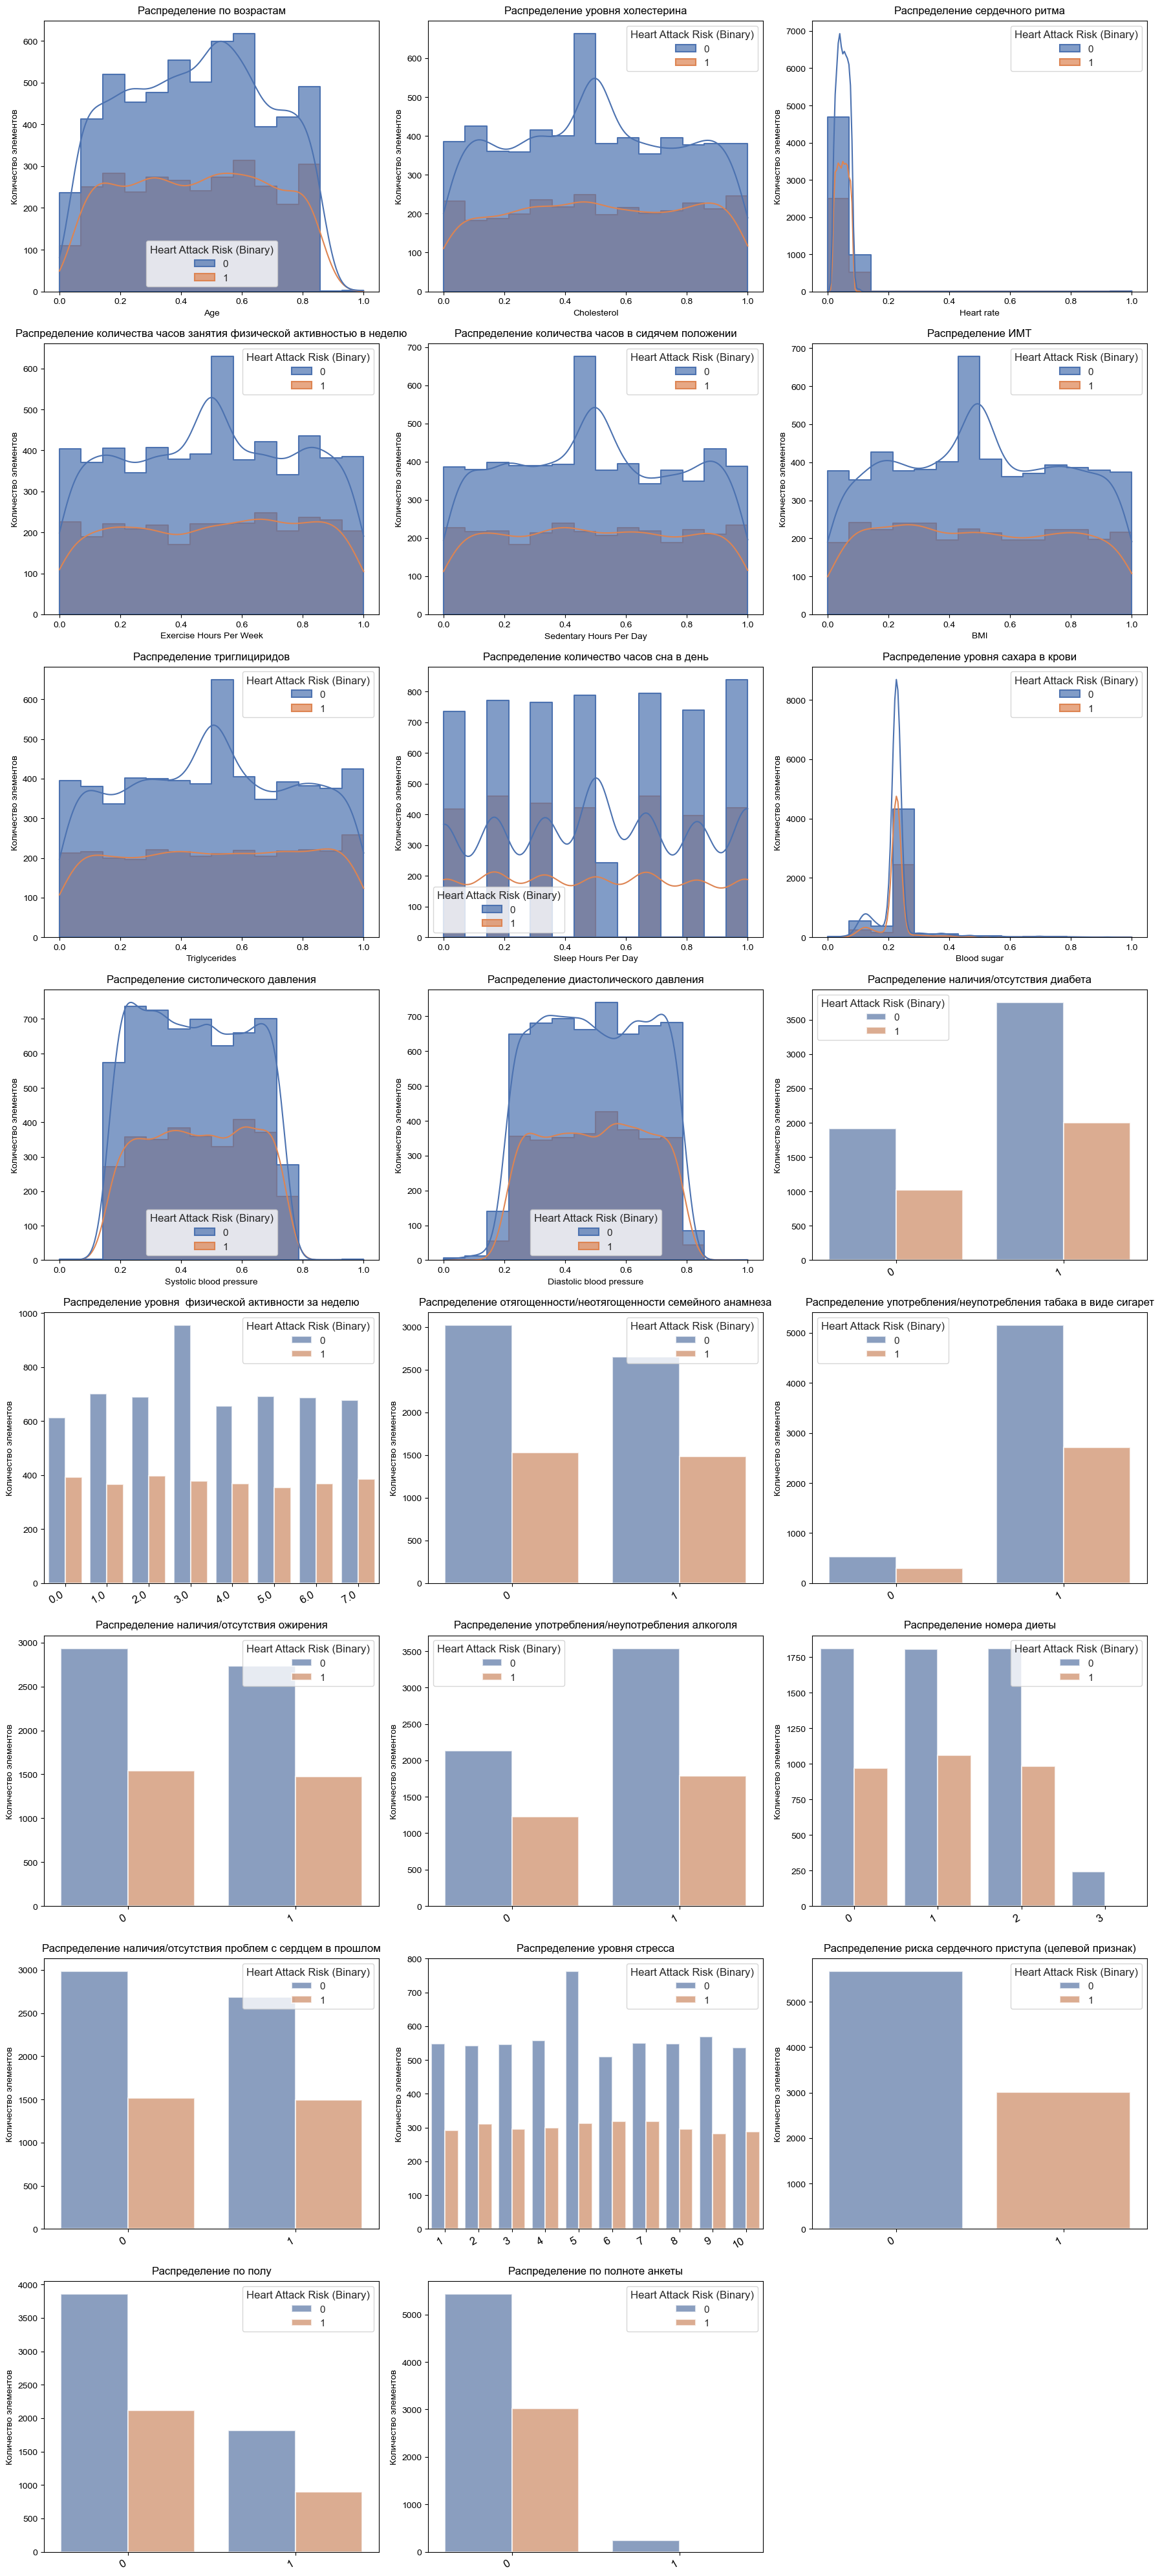

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id,incomplete
count,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,...,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,0.449958,0.501070,0.050658,0.661831,0.475878,0.905584,0.484398,0.613126,0.503378,1.057455,...,0.503737,0.346920,0.227339,0.048159,0.036689,0.312723,0.450295,0.497634,4831.210823,0.027979
std,0.231174,0.284716,0.023453,0.473114,0.499447,0.292423,0.499785,0.487062,0.284810,0.866645,...,0.328061,0.476017,0.076635,0.075531,0.060157,0.463629,0.170184,0.171830,2782.585625,0.164923
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,0.000000,...,0.166667,0.000000,0.227018,0.048229,0.036512,0.000000,0.303226,0.348837,2425.000000,0.000000
50%,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,1.000000,...,0.500000,0.000000,0.227018,0.048229,0.036512,0.000000,0.445161,0.500000,4837.000000,0.000000
75%,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,2.000000,...,0.833333,1.000000,0.227018,0.048229,0.036512,1.000000,0.600000,0.651163,7242.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9650.000000,1.000000


In [21]:
plot_all(train,dict_cont,label_dict_cat=dict_cat,hue='Heart Attack Risk (Binary)')

C:\Users\TEMON\AppData\Local\Temp\ipykernel_76956\369325525.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right',fontsize=12)
C:\Users\TEMON\AppData\Local\Temp\ipykernel_76956\369325525.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right',fontsize=12)
C:\Users\TEMON\AppData\Local\Temp\ipykernel_76956\369325525.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right',fontsize=12)
C:\Users\TEMON\AppData\Local\Temp\ipykernel_76956\369325525.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or us

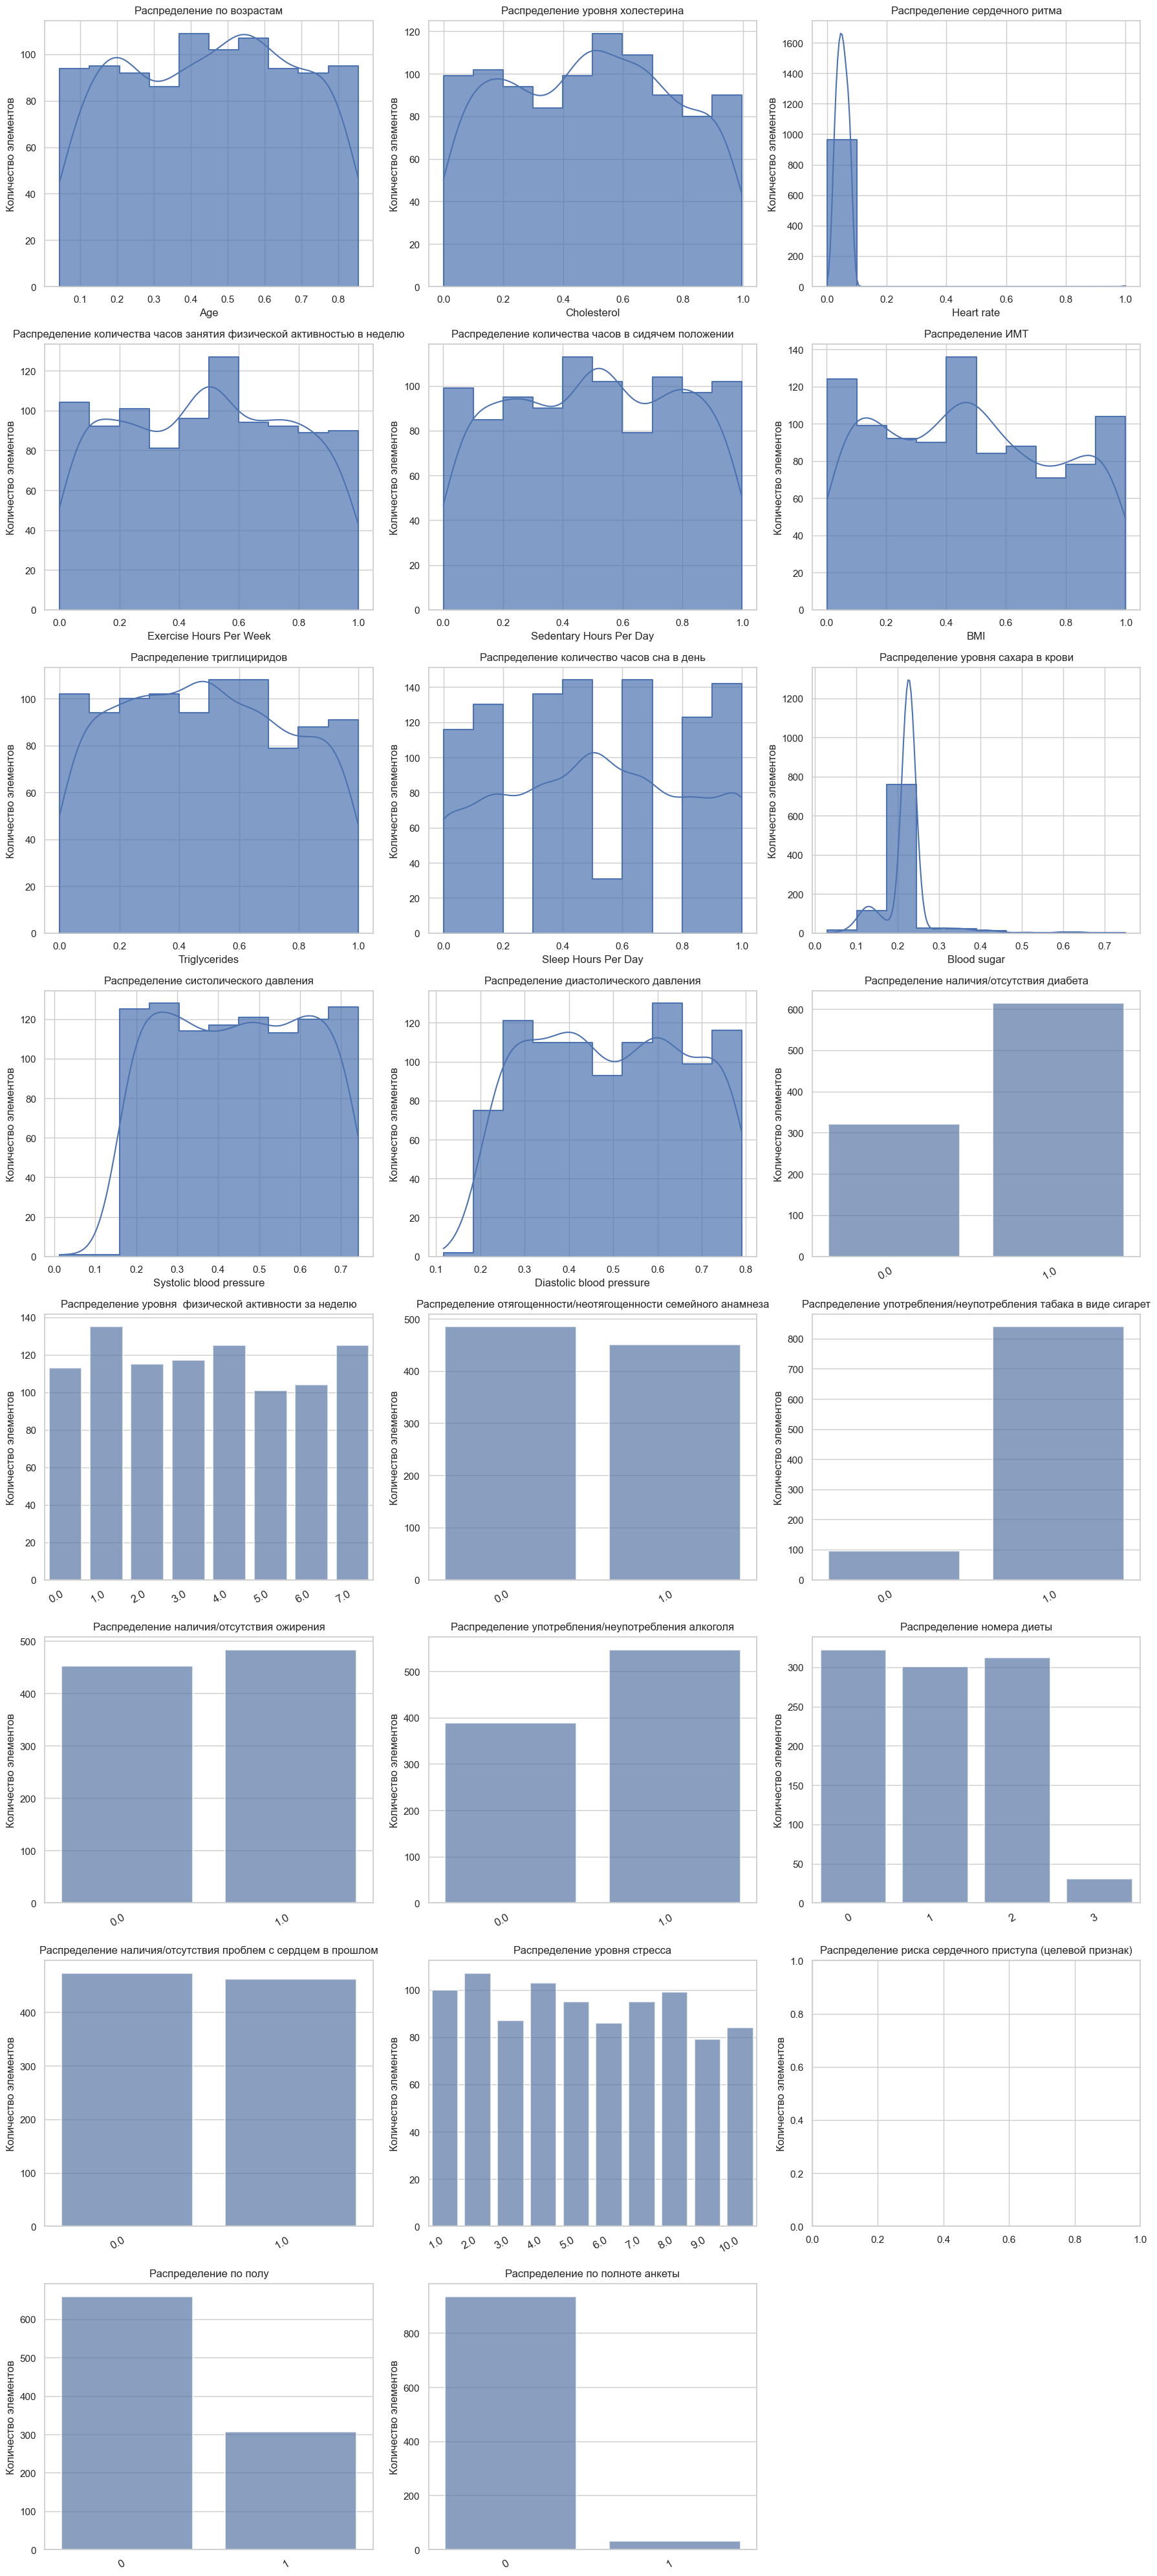

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id,incomplete
count,966.000000,966.000000,966.000000,935.000000,935.000000,935.000000,935.000000,935.000000,966.000000,966.000000,...,935.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000
mean,0.452916,0.488181,0.051644,0.656684,0.481283,0.898396,0.516578,0.583957,0.490706,1.053830,...,3.443850,0.512571,0.224127,0.048855,0.034926,0.317805,0.447172,0.496822,4769.160455,0.032091
std,0.231068,0.282039,0.035502,0.475070,0.499917,0.302289,0.499993,0.493165,0.284902,0.884642,...,2.302778,0.322292,0.065270,0.079742,0.053855,0.465865,0.171837,0.173935,2818.815407,0.176333
min,0.044944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,...,0.000000,0.000000,0.029644,0.000000,0.000194,0.000000,0.012903,0.116279,0.000000,0.000000
25%,0.247191,0.243750,0.036664,0.000000,0.000000,1.000000,0.000000,0.000000,0.243431,0.000000,...,1.000000,0.166667,0.227018,0.048229,0.036512,0.000000,0.296774,0.348837,2275.750000,0.000000
50%,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,1.000000,1.000000,0.502110,1.000000,...,3.000000,0.500000,0.227018,0.048229,0.036512,0.000000,0.445161,0.488372,4769.500000,0.000000
75%,0.640449,0.710714,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.734425,2.000000,...,5.000000,0.833333,0.227018,0.048229,0.036512,1.000000,0.600000,0.639535,7206.000000,0.000000
max,0.853933,0.996429,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998938,3.000000,...,7.000000,1.000000,0.750988,1.000000,0.970871,1.000000,0.741935,0.790698,9644.000000,1.000000


In [22]:
plot_all(test,dict_cont,label_dict_cat=dict_cat)

### Промежуточный вывод 3

Принципиальных отличий в распределениях данных на тренировочной и тестовой выборок нет. 

Значения всх непрервных признаоов лежат в диапазоне (0,1)
В тренировочной выборке имеется  дисбалансов классов по отношению к целевому признаку. В небинарных данных средняя и медиана довльно близки. Распределения большинства таких признаков близки к равномерному (среднее отклонение велико относительно самих данных).  


### Корреляционный анализ

In [23]:
def heatmap(data,interval_cols=''):
    sns.heatmap(data.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f') 
    plt.gcf().set_size_inches(10, 10)
    plt.show()

In [24]:
interval_cols = train.select_dtypes(include=['float64']).columns  

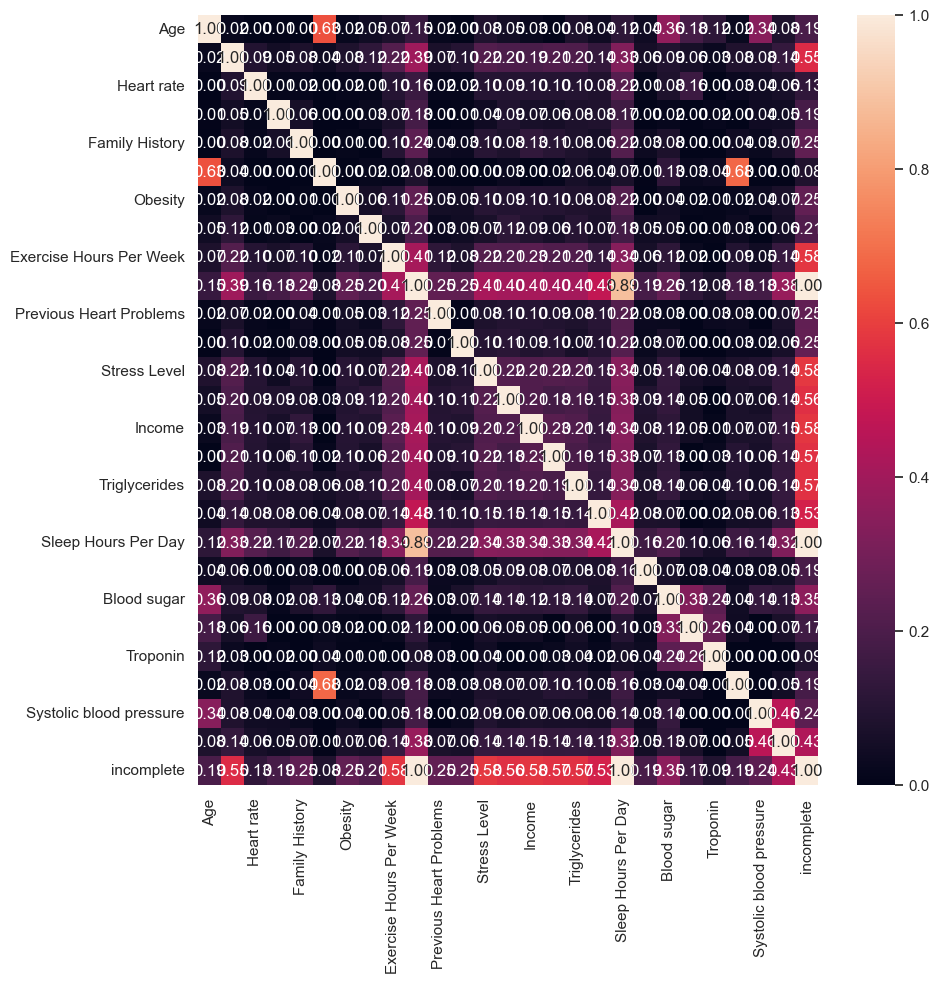

In [25]:
heatmap(train.drop('id',axis=1),interval_cols=interval_cols)

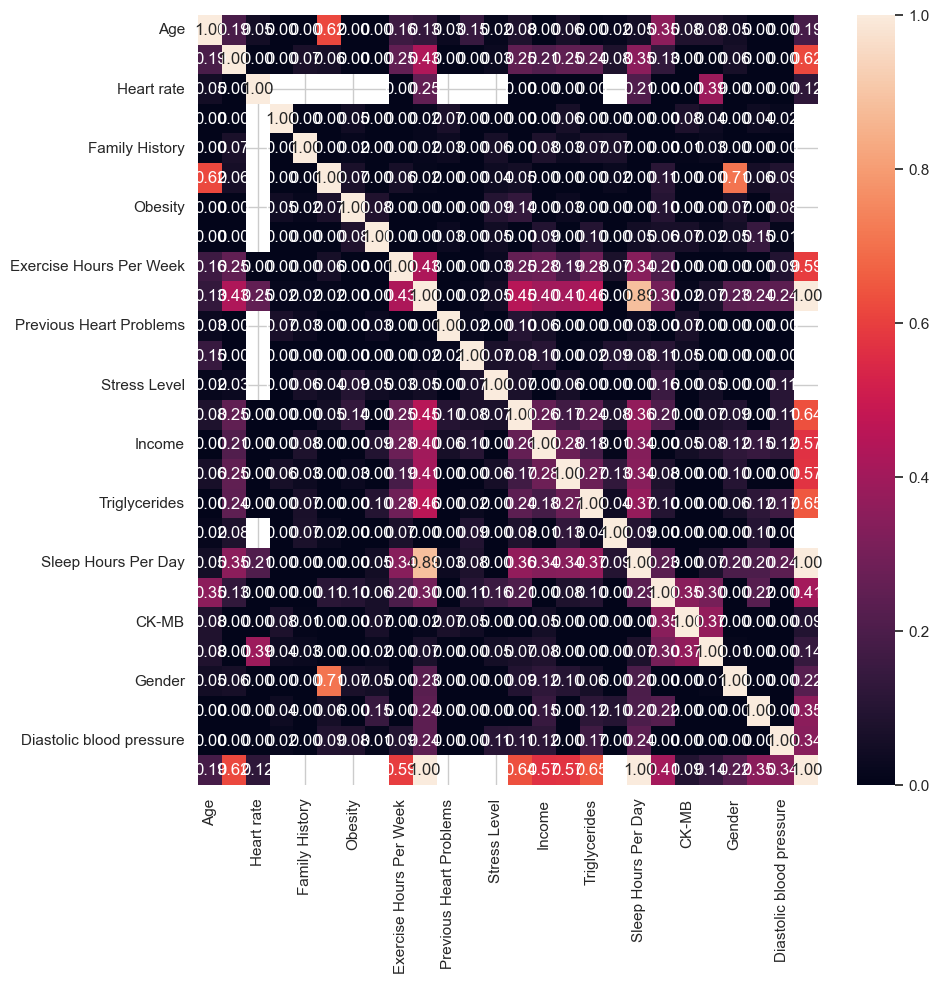

In [26]:
heatmap(test.drop('id',axis=1),interval_cols=interval_cols)

### Промежуточный вывод 4

Сильно скоррелированных (>0.9) признаков нет. Кроме 'incomplete' - искусственно созданного признака. Одднако, его корреляция понятна и  этот признак нужен  только для неполных данных. На качество нелинейнных моделей это не повлияет

## Модель

Так как дисбаланс классов не велик, удобно будет сравнивать модели по порог-независимой метрике roc-auc. После  получения наилучей модели будет подобран оптимальный порог под наши задачи.

### Dummy model

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(
        train.drop(
            ['Heart Attack Risk (Binary)','id'], 
            axis=1
        ),
        train['Heart Attack Risk (Binary)'],
        stratify = train['Heart Attack Risk (Binary)'],
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE
    )

In [28]:
dummy_class = DummyClassifier(strategy="most_frequent")
dummy_class.fit(X_train,y_train)
prediction_dum =  dummy_class.predict(X_valid)
print(roc_auc_score(y_valid,prediction_dum))

0.5


### Промежуточный вывод 5 

Предсказание самым частым дает ожидаемый 0.5roc-auc

### Baseline

В качестве baseline выступит линейная регрессия

In [29]:
features_to_drop

['Income', 'Medication Use', 'Troponin', 'CK-MB']

In [30]:
num_columns = [
    'Age', 'Cholesterol', 'Heart rate', 'Exercise Hours Per Week',
    'Sedentary Hours Per Day', 'BMI', 'Triglycerides',
    'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Blood sugar',
    'Systolic blood pressure', 'Diastolic blood pressure'
]
bin_columns= [
     'Diabetes','Family History','Smoking',
     'Obesity','Alcohol Consumption','Previous Heart Problems',
     'incomplete','Gender'
]

ohe_columns = [
    'Diet'
]

In [31]:
num_pipe = Pipeline(
    [
        (
            'simpleImputer_num', 
            SimpleImputer(missing_values=np.nan, strategy='median')
        ),        
        (
            'scale_num', StandardScaler()
        )
    ]
)

In [32]:
bin_pipe  = Pipeline(
[
    ('simpleImputer_before_bining', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
]
)

In [33]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

In [34]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('bins',bin_pipe,bin_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='drop'
) 

In [35]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE,class_weight='balanced',solver='saga',max_iter=5000))
    ]
) 

In [36]:
param_distributions = [ 
    {       
        'models__penalty' : ['l2','l1'],
        'models__C': [0.001, 0.01, 0.1, 1, 10, 100,500,1000, 10000],
        'preprocessor__num__scale_num': [StandardScaler(),MinMaxScaler(),RobustScaler()],

    },
    {   
        'models__penalty' : ['elasticnet'],
        'models__C': [0.001, 0.01, 0.1, 1, 10, 100,500,1000, 10000],
        'models__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9,0.99],
        'preprocessor__num__scale_num': [StandardScaler(),MinMaxScaler(),RobustScaler()],

    }
] 

In [37]:
start_time = time.time()

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    cv=5, 
    scoring='roc_auc',
    n_jobs = -1,
    verbose=3,
    n_iter = 500,
    random_state = RANDOM_STATE
)

randomized_search.fit(X_train, y_train)

end_time = time.time()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\TEMON\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 216 is smaller than n_iter=500. Running 216 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [38]:
print(f'Затраченное время:\n {(end_time - start_time) / 60 :.2f} минут') 
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_) 
print('Лучшая модель и её параметры:\n\n', randomized_search.best_params_) 

Затраченное время:
 1.47 минут
Метрика ROC-AUC для лучшей модели:
 0.5391604958303313
Лучшая модель и её параметры:

 {'preprocessor__num__scale_num': MinMaxScaler(), 'models__penalty': 'l2', 'models__C': 0.1}


In [39]:
y_pred_test = randomized_search.best_estimator_.predict_proba(X_valid)[:, 1]
roc_auc_test = roc_auc_score(y_valid, y_pred_test)
print(roc_auc_test)

0.5183291369396131


### Промежуточный вывод 6

Линейная регрессия оказалась лишь немногим лучше dummy model. Результат на кросс-валидации - 0.539, на валидационной выборке - 0.518

### Random Forest

In [40]:
pipe_final_tree = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', RandomForestClassifier(
            n_estimators=300,
            min_samples_split=5,
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=RANDOM_STATE,
            class_weight='balanced'
        )
        )
    ]
) 

In [41]:
param_distributions_tree = [ 
    {
        'models__n_estimators': [300, 600, 1000],
        'models__max_depth': range(2, 20),
        'models__min_samples_leaf': range(3, 80),
        'models__min_samples_split': range(3, 50),
        'models__max_features': ['sqrt', 'log2', None, 0.5, 0.8],
    }
] 

In [42]:
start_time = time.time()

randomized_search = RandomizedSearchCV(
    pipe_final_tree, 
    param_distributions=param_distributions_tree, 
    cv=5, 
    scoring='roc_auc',
    n_jobs = -1,
    verbose=3,
    n_iter = 200,
    random_state = RANDOM_STATE
)

randomized_search.fit(X_train, y_train)

end_time = time.time()

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [43]:
print(f'Затраченное время:\n {(end_time - start_time) / 60 :.2f} минут') 
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_) 
print('Лучшая модель и её параметры:\n\n', randomized_search.best_params_) 

Затраченное время:
 7.59 минут
Метрика ROC-AUC для лучшей модели:
 0.5877915005314501
Лучшая модель и её параметры:

 {'models__n_estimators': 300, 'models__min_samples_split': 6, 'models__min_samples_leaf': 6, 'models__max_features': 'log2', 'models__max_depth': 19}


In [44]:
y_pred_test = randomized_search.best_estimator_.predict_proba(X_valid)[:, 1]
roc_auc_test = roc_auc_score(y_valid, y_pred_test)
print(roc_auc_test)

0.6134887557848503


### Промежуточный вывод 7

Random forest показал чуть более ссущественный результат: 0.588 на кросс-валидации и 0.613 на валидационной выборке. В целом это говорит о том, что в данных сигнал очень слабый, что даже ансамбль из случайных деревьев с глубиной 19 дает такой посредственный  результат.  

### Улучшение модели

Подберем параметры модели с помощью поиска с баесовской оптимизацией

In [45]:
param_distributions_tree_optuna = {
        'models__n_estimators': IntDistribution(50,1000,step=10),
        'models__max_depth': IntDistribution(10,50),
        'models__min_samples_leaf': IntDistribution(5, 20),
        'models__min_samples_split': IntDistribution(5, 20)
    }


In [46]:
pipe_final_tree_optuna = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', RandomForestClassifier(
            n_jobs=-1,
            random_state=RANDOM_STATE,
            class_weight='balanced',
            max_features = 'log2'
        )
        )
    ]
) 

In [47]:
start_time = time.time()

optuna_search_tree = OptunaSearchCV(
        pipe_final_tree_optuna, 
        param_distributions=param_distributions_tree_optuna, 
        cv=5, 
        scoring='roc_auc',
        verbose=3,
        n_trials=300,
        random_state = RANDOM_STATE
    )



optuna_search_tree.fit(X_train, y_train)

end_time = time.time()

C:\Users\TEMON\AppData\Local\Temp\ipykernel_76956\898423896.py:3: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search_tree = OptunaSearchCV(
[I 2026-02-08 16:47:39,960] A new study created in memory with name: no-name-cbb6abd2-8c32-454b-8220-a114ab4cad15
[I 2026-02-08 16:47:41,435] Trial 0 finished with value: 0.5759623667450179 and parameters: {'models__n_estimators': 220, 'models__max_depth': 15, 'models__min_samples_leaf': 8, 'models__min_samples_split': 8}. Best is trial 0 with value: 0.5759623667450179.
[I 2026-02-08 16:47:41,935] Trial 1 finished with value: 0.5586385190281966 and parameters: {'models__n_estimators': 50, 'models__max_depth': 36, 'models__min_samples_leaf': 20, 'models__min_samples_split': 16}. Best is trial 0 with value: 0.5759623667450179.
[I 2026-02-08 16:47:46,098] Trial 2 finished with value: 0.57077598725386 and parameters: {'models__n_estimators': 670, 'models__max_depth': 15,

In [48]:
print(f'Затраченное время:\n {(end_time - start_time) / 60 :.2f} минут') 
print('Метрика ROC-AUC для лучшей модели:\n', optuna_search_tree.best_score_) 
print('Лучшая модель и её параметры:\n\n', optuna_search_tree.best_params_) 

Затраченное время:
 20.40 минут
Метрика ROC-AUC для лучшей модели:
 0.5884002639040065
Лучшая модель и её параметры:

 {'models__n_estimators': 560, 'models__max_depth': 19, 'models__min_samples_leaf': 6, 'models__min_samples_split': 12}


In [49]:
y_pred_test = optuna_search_tree.best_estimator_.predict_proba(X_valid)[:, 1]
roc_auc_test = roc_auc_score(y_valid, y_pred_test)
print(roc_auc_test)

0.615120859880356


In [50]:
model = optuna_search_tree.best_estimator_

### Промежуточный  вывод 8 

Удалось несколько улучшить  модель и подняться до 0.588 на кросс-валидации. 

### Анализ важности признаков

Проанализируем важность признаков с помощью значений Шеллли

In [51]:
pre = model.named_steps['preprocessor']
forest = model.named_steps['models']
feature_names = pre.get_feature_names_out()

**Значения Шелли считаются долго** 

Пришлось взять большую подвыборку, потому что от размеры выборки силльно менялся результат. Видимо, данные довольно уникальны - поэтому и сигнал слабый, много уникальных случаев. 

In [72]:
X_sample = X_train.sample(4000, random_state=RANDOM_STATE)
X_sample_t = pre.transform(X_sample)
X_sample_t = pd.DataFrame(X_sample_t, columns=feature_names)

In [73]:
explainer = shap.TreeExplainer(forest)
shap_exp = explainer(X_sample_t)

Text(0.5, 1.0, 'SHAP-значения для признаков модели')

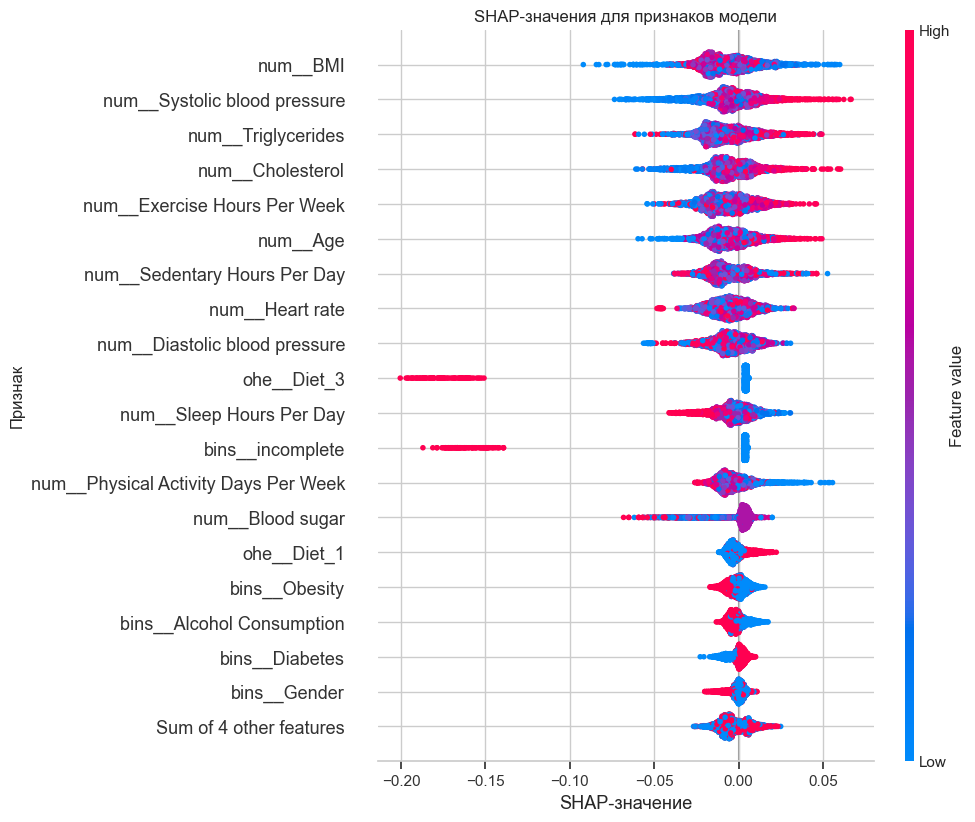

In [74]:
fig, ax = plt.gcf(), plt.gca()
shap.plots.beeswarm(shap_exp[..., 1], max_display=20, show=False)
ax.set_ylabel('Признак')
ax.set_xlabel('SHAP-значение')
ax.set_title('SHAP-значения для признаков модели')

Text(0.5, 1.0, 'Средние SHAP-значения для признаков модели')

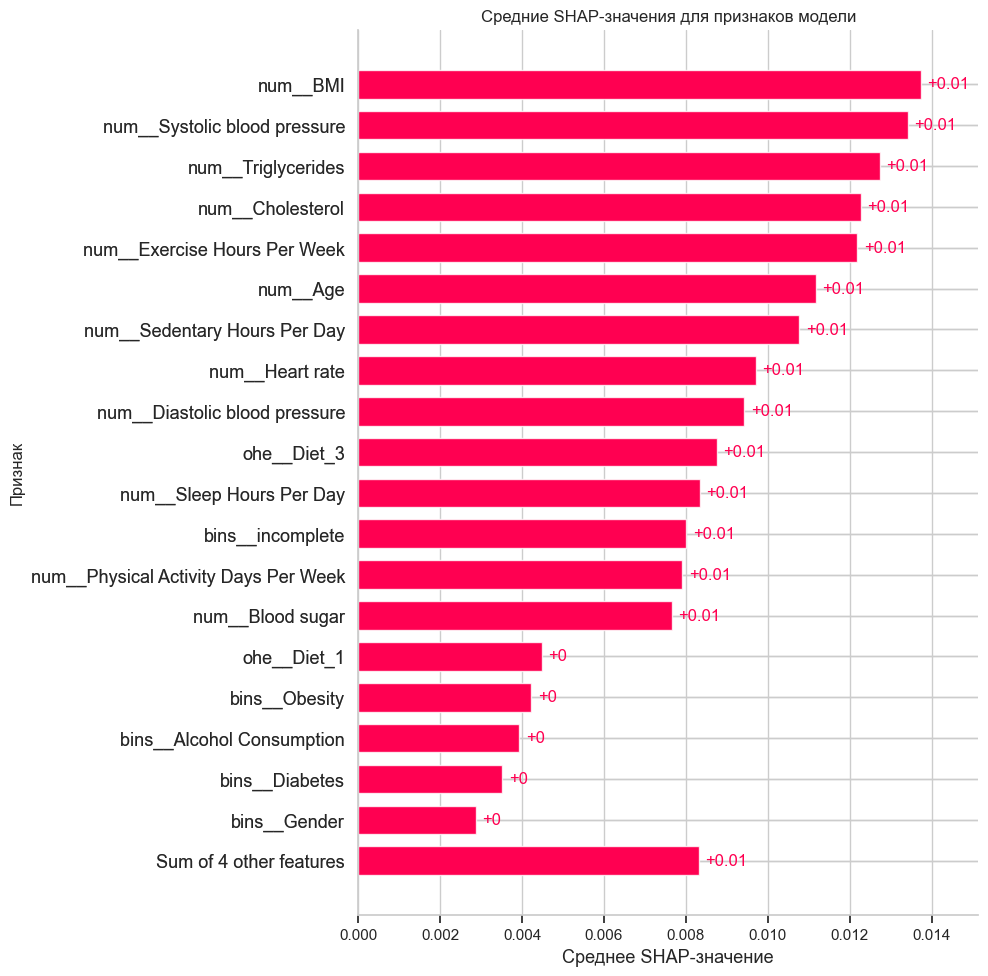

In [75]:
fig, ax = plt.gcf(), plt.gca()
shap.plots.bar(shap_exp[..., 1],max_display=20,show=False) 
ax.set_ylabel('Признак')
ax.set_xlabel('Среднее SHAP-значение')
ax.set_title('Средние SHAP-значения для признаков модели')

### Промежуточный вывод 9

Наиболее существенные признаки: 
- ИМТ
- Систолическое давление
- Уровень триглициридов
- Уровень холестерина
- Количество активных часов в неделю
- Количество сидячих часов в день

В целом, не один признак не превалирует над  остальными - слабый сигнал в данных. 

Высокий риск сердечного приступа связан с:

- Высоким систолическим давлением
- Высокими значениясм триглициридов и холестерина
- Возрастом
- Высоким (!?) значением активных часов в неделю

ИМТ можно интепретировать так, что и низкий и высокий ИМТ могут быть факторами риска. 

### Подбор порога

Для медицинского исследования такого рода важнее всего предупредить пациента о возможных рисках и необходимости провести дополнительное обследование.
Следовательно, целевым для нас будет recall. Балланс между precision и recall будем находить максимизацией f2-метрики (сдвинулись в польщу recall)

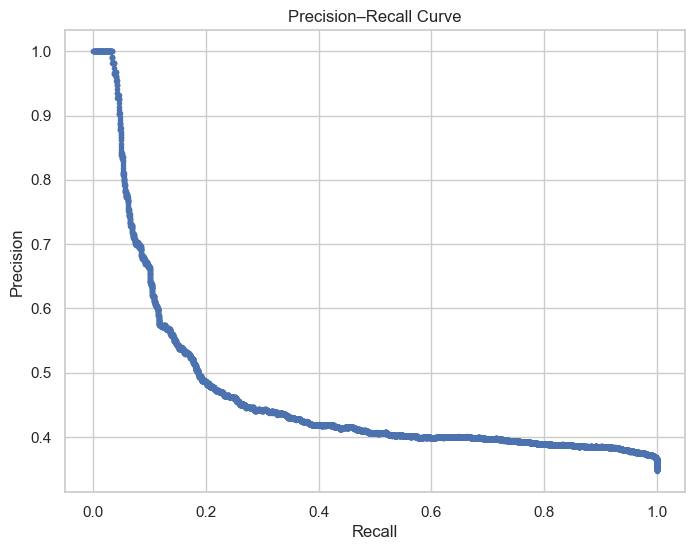

In [76]:
cv = StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=RANDOM_STATE
    )
y_prob = cross_val_predict(model,
                           train.drop(['Heart Attack Risk (Binary)','id'], axis=1),
                           train['Heart Attack Risk (Binary)'],method="predict_proba",
                           cv=cv)[:, 1]

precision, recall, thresholds = precision_recall_curve(train['Heart Attack Risk (Binary)'], y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.grid(True)
plt.show()

In [77]:
def optimum_thr(linspace):
    print(f"thr  | recall | precision | accuracy | f2_score")
    
    cv = StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=RANDOM_STATE
    )
    y_prob = cross_val_predict(model,
                               train.drop(['Heart Attack Risk (Binary)','id'], axis=1),
                               train['Heart Attack Risk (Binary)'],method="predict_proba",
                               cv=cv)[:, 1]
    
    for thr in linspace:
        y_test = train['Heart Attack Risk (Binary)']
        y_pred = (y_prob >= thr).astype(int)
        r = recall_score(y_test, y_pred)
        p = precision_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        f2_score = fbeta_score(y_test, y_pred,beta=2)
        print(f"{thr:4.3f} | {r:6.3f} |   {p:6.3f}  | {acc:6.3f}   | {f2_score:6.3f}")

In [80]:
optimum_thr(np.linspace(0.322, 0.353, 10))

thr  | recall | precision | accuracy | f2_score
0.322 |  1.000 |    0.366  |  0.399   |  0.743
0.325 |  1.000 |    0.367  |  0.401   |  0.743
0.329 |  0.999 |    0.367  |  0.401   |  0.743
0.332 |  0.999 |    0.368  |  0.403   |  0.743
0.336 |  0.998 |    0.368  |  0.405   |  0.744
0.339 |  0.997 |    0.369  |  0.407   |  0.744
0.343 |  0.996 |    0.369  |  0.409   |  0.744
0.346 |  0.995 |    0.370  |  0.410   |  0.744
0.350 |  0.993 |    0.371  |  0.412   |  0.743
0.353 |  0.992 |    0.371  |  0.414   |  0.744


In [81]:
thr = 0.325

### Промежуточный вывод 10

Оптимальным порогом можно считать 0.325.  При этом recall = 1, accuracy 0.4 - то есть в сорока процентах  случаев верно предсказываем риск сердечного приступа - очень неплохо для медицинского исследования. 

### Сохранение модели

In [82]:
model.fit(train.drop(
            ['Heart Attack Risk (Binary)','id'], 
            axis=1
        ),
        train['Heart Attack Risk (Binary)'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Diet']),
                                                 ('bins',
                                                  Pipeline(steps=[('simpleImputer_before_bining',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Diabetes'...
                                                   'Exercise Hours Per Week',
                                                   'Sedentary Hours Per Day',
                                                   'BMI', 'Triglycerides',
                                                   'Physical Activity Days Per '
                                                   'Week',
                                                   'Sleep Hours Per Day',
                                                   'Blood sugar',
                                                   'Systolic blood pressure',
                                                   'Diastolic blood '
                                                   'pressure'])])),
                ('models',
                 RandomForestClassifier(class_weight='balanced', max_depth=19,
                                        max_features='log2', min_samples_leaf=6,
                                        min_samples_split=12, n_estimators=560,
                                        n_jobs=-1, random_state=703))])

In [83]:
#joblib.dump(model, "Heart_Attack_Risk_Model.pkl")

['Heart_Attack_Risk_Model.pkl']

### Предсказание на тестовой выборке

In [84]:
y_prob = model.predict_proba(test)[:, 1]
y_pred = (y_prob >= thr).astype(int)

In [85]:
test['prediction'] = y_pred

In [86]:
#test[['id','prediction']].to_csv('prediction.csv',index=False)

## Результаты

### Проделанная работа

- Исходные данные представлены обучающей выборкой, размером 8685 элементов,  размерность пространства признаков - 26,  включая целевой признак и id пациента. Целевой признак бинарен (1 - высокий риск  сердечного приступа). Тестовые данные представлены 966 элементами. Признаки: 
     - Антропометрические параметры (вес, возраст, рост)
     - Привычки (курение, качество сна и т.д)
     - Давление
     - Наличие хронических заболеваний
     - Биохимия крови
     - Таргет - высокий или низкий риск поражения сердца
- Данные приведены к нужным типам. Часть призннаков мусорны ('Income','Medication Use') или представляют собой утечку целевого признака ('Troponin','CK-MB'). Они не вошли в модель.
- В данных присутствуют пациенты с сильно незаполненными данными. Полное их удаление может привести к потери важной информации. Для того, чтобы зафиксировать, что данные объекты имеют неполную анкеты, был создан признак 'incomplete', которые имеет значение 1, если имеются множественные пропуски.
- Тренировочная и тестовая выборки согласованы. В тренировочной выборке имеется дисбалансов классов по отношению к целевому признаку. В небинарных данных средняя и медиана довльно близки. Распределения большинства таких признаков близки к равномерному (среднее отклонение велико относительно самих данных).
- Мультиколлиниарности в признаках нет
- Так как дисбаланс классов не велик, в качестве метрики была выбрана порог-независимая метрика roc-auc.
- Логистическая регрессия показала себя немногим лучше модели, предсказывающей класс по наиболее часто встречающуемуся. Результат на кросс-валидации - 0.539, на валидационной выборке - 0.518 
- Основная модель - random forest. С помощью поиска с баесовской оптимизацией получена следующая наилучшая модель:
    - n_estimators - 560
    - max_depth - 19
    - min_samples_leaf - 6
    - min_samples_split - 12
    - max_features - 'log_2'
- Результат на кросс-валидации - 0.588, на валидационной выборке - 0.615
- Был произведен анализ признаков на основе значений Шелли:
    - Наиболее существенные признаки:
        - ИМТ
        - Систолическое давление
        - Уровень триглициридов
        - Уровень холестерина
        - Количество активных часов в неделю
        - Количество сидячих часов в день
    - В целом, не один признак не превалирует над остальными - слабый сигнал в данных.
    - Высокий риск сердечного приступа связан с:
        - Высоким систолическим давлением
        - Высокими значениясм триглициридов и холестерина
        - Возрастом
        - Высоким (!?) значением активных часов в неделю
        - ИМТ можно интепретировать так, что и низкий и высокий ИМТ могут быть факторами риска.
- Для медицинского исследования такого рода важнее всего предупредить пациента о возможных рисках и необходимости провести дополнительное обследование. Следовательно, целевая метрика -  recall. Балланс между precision и recall находился максимизацией f2-метрики.
- Оптимальный порог - 0.325.  При этом recall = 1, accuracy 0.4 - то есть в сорока процентах случаев верно предсказываем риск сердечного приступа - очень неплохо для медицинского исследования. 

### Общий вывод

В целом, итоговое значение roc auc 0.59 оставляет желать лучшего (по сравнению с dummy - 0.5). Анализ говорит, что в данных сигнал довольно слабый. Об этоом свидетельствует как относительно незначительный рост метрики при переходе от линейной  модели к нелинейной, так и тот факт, что от размера выборки силльно менялся результат анализа значений Шелли. 

Однако удалось добиться recall = 1 при accuracy в 0.4, что является хорошим результатом в медицинских данных. 